In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2024-01-31 14:07:56.082884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 14:07:59.479475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
ReadList = ["Mass", "evt_trig", "fourjetmasstev",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [3]:
def add_more_cols(DF):
    DF["Truth"] = (DF["Mass"] > 0).astype(int)

In [4]:
def make_training_and_testing_pd(Input):
    FileName = "ML_TTree/tree_ML_MCRun2_"
    if isinstance(Input, str):
        FileName = FileName + Input  + ".root"
    else:
        FileName = FileName + str(Input) + "GeV.root"
    
    print("Processing file: " + FileName + "\n")
    Events = uproot.open(FileName)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    TrainingDF = None
    TestingDF = None
    TrainingRows = 100000
    TestingRows = 50000
    
    if isinstance(Input, str):
        if "QCD" in Input:
            ### inclusive QCD sample. shuffle before splitting into training and testing ###
            DF = DF.sample(frac = 1).reset_index(drop=True)
            TrainingDF = DF.loc[0:TrainingRows*12-1]
            TestingDF = DF.loc[TrainingRows*12:TrainingRows*12+TestingRows*12-1]
        else:
            ### Each resonant signal only has ~90k events. So use all in training ###
            TrainingDF = DF
            TestingDF = DF.loc[0:TestingRows-1]
    else:
        TrainingDF = DF.loc[0:TrainingRows-1]
        TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
        
    return [TrainingDF, TestingDF]

In [5]:
InputList = ["QCD_2M_stride30", 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000,
             "Ms2000_Mc500", "Ms4000_Mc1000", "Ms6000_Mc1600", "Ms8000_Mc2000", "Ms9000_Mc2250", "Ms8000_Mc3000"]

SanityCheckPlots = True

In [6]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, InputList)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root


Processing file: ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms2000_Mc500.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms4000_Mc1000.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms6000_Mc1600.root

Processing file: ML_TTree/tree_ML_MCRun2_Ms8000_Mc2000.root

Processing file: ML_TTree/tree_ML_MCRun

In [7]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
0,0,1,2.739371,2.084053,0.628178,1.196355,0.849611,0.587116,0.544583,3.325948,3.565834,2.522093,2.368517,1.601122,1.443953,0
1,0,1,4.167748,2.374347,1.120746,2.277627,0.879338,2.064021,0.551780,2.824532,2.415796,2.927734,1.988485,3.928176,0.716459,0
2,0,1,3.215953,1.929389,1.277904,1.577658,1.520885,0.379792,0.243311,4.402951,3.609703,3.817105,3.739675,0.834142,0.701702,0
3,0,1,2.183398,1.592064,0.476591,0.938920,0.922025,0.488939,0.264787,2.955106,2.598642,3.127938,3.148205,1.476042,0.529638,0
4,0,1,1.382362,1.084386,0.222766,0.646556,0.400828,0.316070,0.121195,3.140200,2.061353,3.233332,2.530344,1.248062,0.496642,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944793,3000,1,6.535932,5.377786,0.660737,2.650431,1.764363,1.405020,1.210117,2.720518,1.605185,2.551869,2.701236,1.115265,1.293146,1
2944794,3000,1,5.224732,2.882598,1.822171,2.629615,1.000931,2.591036,1.091268,3.060042,2.335114,2.170200,1.137318,2.177055,1.220143,1
2944795,3000,1,7.592826,3.582301,3.522391,3.438700,2.153276,2.932984,2.748832,2.838997,2.578493,2.086794,1.545883,2.495052,2.739778,1
2944796,3000,1,6.927839,3.575580,2.809887,2.832127,2.356437,2.788135,2.505780,3.536083,2.532907,2.134949,1.697465,2.161088,2.102989,1


In [8]:
TrainingDF.dtypes

Mass                int32
evt_trig            int32
fourjetmasstev    float64
P1high_MTeV       float64
P1low_MTeV        float64
P2high_MTeV       float64
P2low_MTeV        float64
P3high_MTeV       float64
P3low_MTeV        float64
P1high_dR         float64
P1low_dR          float64
P2high_dR         float64
P2low_dR          float64
P3high_dR         float64
P3low_dR          float64
Truth               int64
dtype: object

In [9]:
Masses = sorted(set(TrainingDF["Mass"]))
print(Masses)

[0, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1600, 1750, 2000, 2250, 2500, 3000]


In [10]:
TrainingDF = TrainingDF.sample(frac = 1)
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
2410708,500,1,1.612471,1.081952,0.245070,0.842225,0.504888,0.487548,0.417098,3.070871,1.523404,3.351531,2.988718,1.930893,2.117167,1
2405971,500,1,1.662474,0.846770,0.666587,0.824422,0.808536,0.465774,0.293274,2.916344,2.918349,2.961143,3.155620,1.062016,0.802760,1
2299765,2500,1,5.606730,3.775147,1.561861,2.514887,2.433278,1.176273,1.090009,3.065152,2.166606,2.892404,3.023229,1.007275,0.924604,1
1823148,1250,1,2.016798,1.243814,0.360030,1.151256,0.361918,0.691559,0.679416,4.068186,1.637790,2.951967,1.796103,2.947079,3.181756,1
794376,0,1,1.564872,1.126294,0.414962,0.780926,0.563616,0.226267,0.207893,3.545387,2.585269,2.782711,3.281273,0.677576,0.798821,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742435,2000,1,6.846753,4.868793,1.270022,3.100585,2.458527,2.013678,1.465240,2.736015,1.635999,2.945837,2.538595,1.388728,1.165667,1
2592928,1600,1,5.381938,4.104446,0.596716,2.851729,1.133864,1.282645,0.891357,3.335466,1.239324,3.056606,1.948129,1.940547,0.819718,1
392071,0,1,4.958839,2.935057,0.236356,2.272387,1.578837,2.136945,1.933075,3.322945,1.102492,2.988622,3.568808,3.873173,3.330836,0
2295660,2500,1,6.213495,4.061659,1.410014,2.694343,0.837103,2.599978,2.332821,2.919310,1.788727,2.178958,0.892286,2.244512,2.529236,1


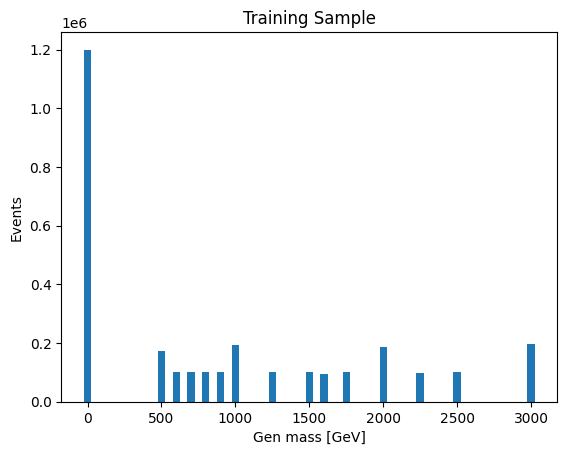

In [11]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

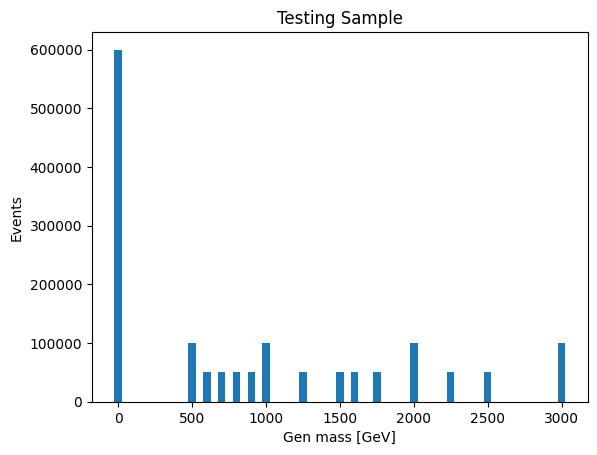

In [12]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

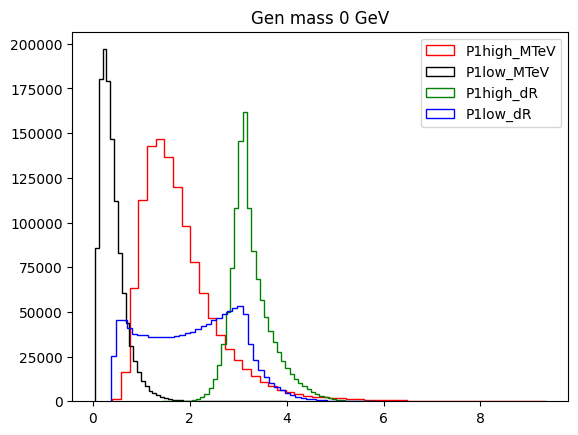

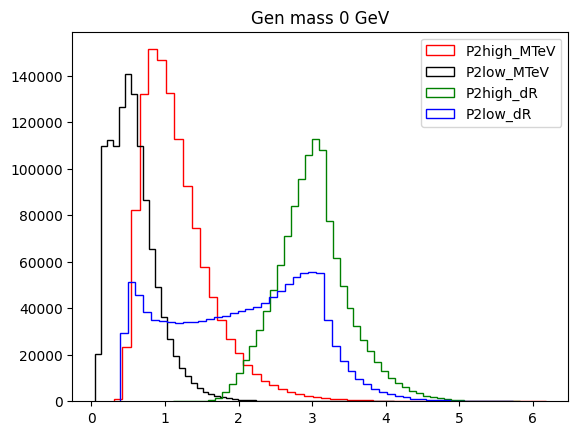

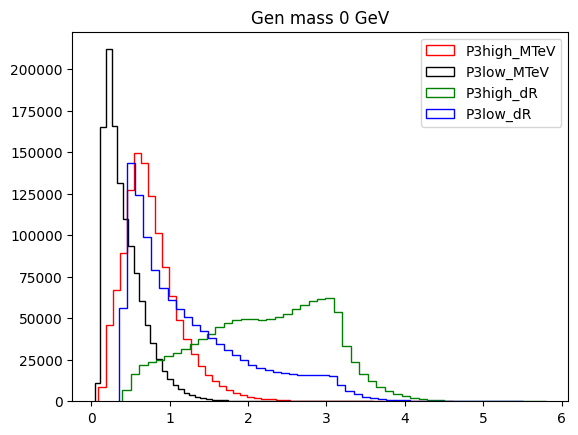

In [13]:
if SanityCheckPlots:
    for Mass in [0]: ### only plot QCD. signal plots are in Dijet_CNN.ipynb ###
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [14]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [15]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(2944798, 15)
(2944798,)
(1500000, 15)


In [16]:
NotebookName = "ResAndNonres_SigBG_CNN_more"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [17]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [18]:
def model_CNN_more():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(32, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNNMore"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [19]:
#Model = model_CNN()
Model = model_CNN_more()

2024-01-31 14:08:21.803018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 14:08:26.656219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [20]:
Model.summary()

Model: "ModelCNNMore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 32)          224       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 model_out (Dense)           (None, 2)                 18        
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-traina

In [21]:
#import pydot
#import graphviz
#tf.keras.utils.plot_model(Model)

In [22]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 100, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/100


2024-01-31 14:08:33.627993: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


472/472 [==============================] - 23s 7ms/step - loss: 0.3894 - accuracy: 0.8184 - val_loss: 0.3520 - val_accuracy: 0.8426
Epoch 2/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3491 - accuracy: 0.8443 - val_loss: 0.3462 - val_accuracy: 0.8455
Epoch 3/100
472/472 [==============================] - 3s 5ms/step - loss: 0.3454 - accuracy: 0.8457 - val_loss: 0.3439 - val_accuracy: 0.8461
Epoch 4/100
472/472 [==============================] - 3s 5ms/step - loss: 0.3437 - accuracy: 0.8464 - val_loss: 0.3422 - val_accuracy: 0.8470
Epoch 5/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3420 - accuracy: 0.8474 - val_loss: 0.3412 - val_accuracy: 0.8479
Epoch 6/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3408 - accuracy: 0.8480 - val_loss: 0.3397 - val_accuracy: 0.8486
Epoch 7/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3399 - accuracy: 0.8484 - val_loss: 0.3400 - val_accuracy: 0.8482
Epoch 8/10

472/472 [==============================] - 3s 5ms/step - loss: 0.3313 - accuracy: 0.8533 - val_loss: 0.3323 - val_accuracy: 0.8526
Epoch 59/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3312 - accuracy: 0.8534 - val_loss: 0.3301 - val_accuracy: 0.8538
Epoch 60/100
472/472 [==============================] - 3s 5ms/step - loss: 0.3311 - accuracy: 0.8534 - val_loss: 0.3313 - val_accuracy: 0.8529
Epoch 61/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3311 - accuracy: 0.8533 - val_loss: 0.3307 - val_accuracy: 0.8535
Epoch 62/100
472/472 [==============================] - 3s 5ms/step - loss: 0.3310 - accuracy: 0.8534 - val_loss: 0.3327 - val_accuracy: 0.8523
Epoch 63/100
472/472 [==============================] - 3s 5ms/step - loss: 0.3311 - accuracy: 0.8535 - val_loss: 0.3311 - val_accuracy: 0.8532
Epoch 64/100
472/472 [==============================] - 2s 5ms/step - loss: 0.3309 - accuracy: 0.8535 - val_loss: 0.3310 - val_accuracy: 0.8533
Epoch

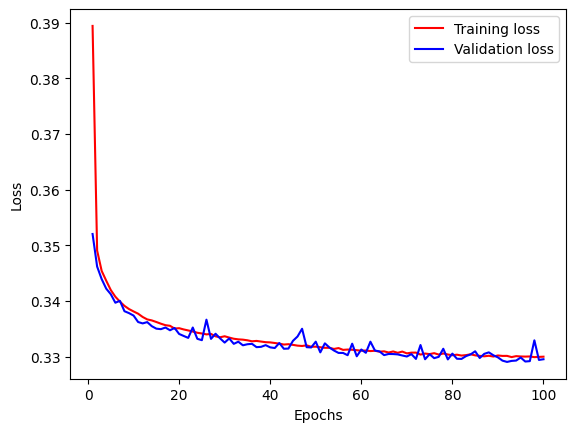

In [23]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [24]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

300/300 [==============================] - 1s 2ms/step


In [25]:
print(TestingOutputs.shape)
print(TestingOutputs[0]) #ML raw output is the probability of 2 sparse categories

(1500000, 2)
[0.99310946 0.00689056]


In [26]:
TestingDF["PredSigProb"] = TestingOutputs[:,1].tolist()
TestingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth,PredSigProb
0,0,1,2.477908,2.245340,0.107534,0.793163,0.293785,0.590359,0.219036,3.356112,0.996557,3.056611,1.033737,2.417182,0.572783,0,0.006891
1,0,1,1.438404,0.846759,0.486215,0.838765,0.311225,0.453807,0.346018,2.939365,3.087705,2.503456,1.916784,1.453761,1.255653,0,0.652974
2,0,1,2.901716,2.364754,0.380377,1.462710,0.534222,0.406494,0.345971,3.238720,2.684885,3.039596,2.582689,0.628835,0.992902,0,0.023974
3,0,1,3.051879,2.497559,0.154463,1.350396,0.181513,0.909142,0.637037,3.403112,0.692505,3.012963,0.559455,3.258116,1.245265,0,0.018187
4,0,1,1.244834,0.945983,0.206380,0.544646,0.341577,0.429737,0.157955,3.051990,1.889009,2.992846,1.543200,1.924028,0.652439,0,0.181764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499995,3000,1,6.350856,4.804782,0.370098,2.818387,1.679034,1.898205,1.693256,3.079867,0.589019,2.524088,1.910917,1.364884,2.403678,1,0.992431
1499996,3000,1,7.045433,4.114034,2.485709,3.623191,1.723898,2.964133,1.423066,2.577298,3.281451,2.339519,1.714503,2.007617,0.997858,1,0.998801
1499997,3000,1,6.106929,3.912739,0.992608,2.851816,1.294218,2.404592,2.350684,2.651374,1.257954,2.106477,1.373415,2.930459,2.127089,1,0.998630
1499998,3000,1,6.691267,4.402146,2.200221,2.549594,2.480623,2.059506,1.999095,2.858452,3.731218,3.120820,2.385565,1.784458,1.811392,1,0.998407


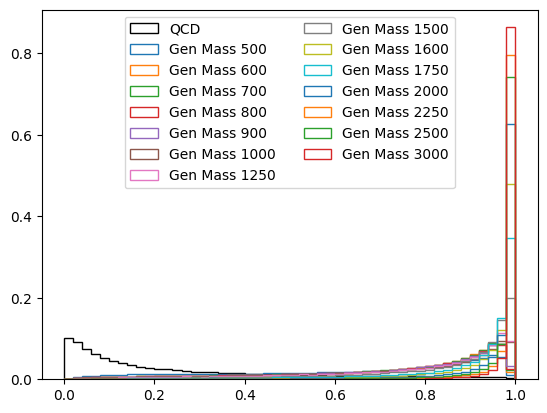

In [27]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")

plt.savefig(ResultsDir + "Pred_Signal_Prob.png")

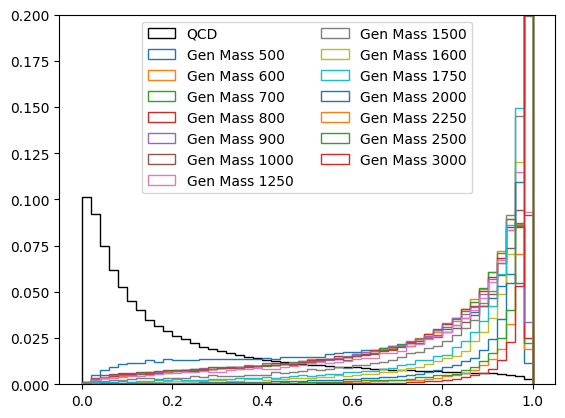

In [28]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")
    plt.ylim(0, 0.2)
    
plt.savefig(ResultsDir + "Pred_Signal_Prob_Zoom.png")

fpr_in_use ['0.0100', '0.0500', '0.1000']
Thresholds ['0.9497', '0.8174', '0.6807']


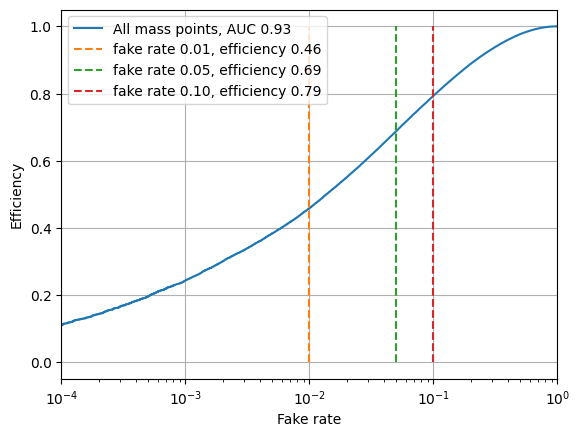

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TestingDF["Truth"].to_numpy(),
                                 TestingDF["PredSigProb"].to_numpy())
roc_auc = auc(fpr, tpr)

#plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
plt.plot(fpr, tpr, label = "All mass points, AUC %.2f" % roc_auc)
plt.xlabel("Fake rate")
plt.ylabel("Efficiency")
plt.xscale("log")
plt.xlim(0.0001, 1)
plt.grid()

FakeRates = [0.01, 0.05, 0.1]
fpr_in_use = []
Thresholds = []
for FakeRate in FakeRates:
    Index = (np.abs(fpr - FakeRate)).argmin()
    fpr_in_use.append(fpr[Index])
    Thresholds.append(thresholds[Index])
    
    plt.plot([FakeRate, FakeRate], [0, 1], linestyle="--",
             label = "fake rate %.2f, efficiency %.2f" % (FakeRate, tpr[Index]))
    
plt.legend()
plt.savefig(ResultsDir + "ROC_all_logX.png")

#print(fpr)
#print(thresholds)
print("fpr_in_use", ["%.4f" % i for i in fpr_in_use])
print("Thresholds", ["%.4f" % i for i in Thresholds])

0.9496676325798035 0.009998333333333333
0.8173694014549255 0.04999833333333333
0.680700421333313 0.1


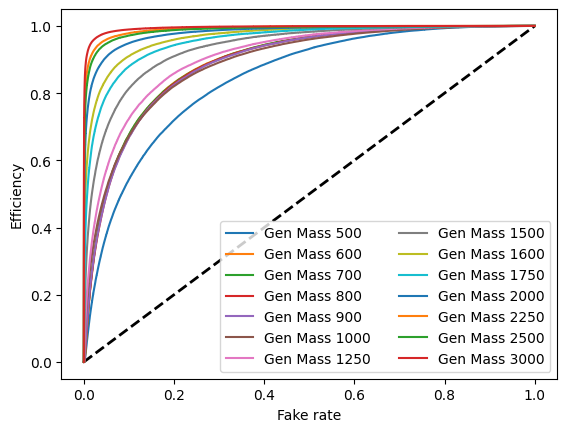

In [30]:
TestingDF_QCD = TestingDF.loc[TestingDF["Mass"] == 0]

for Mass in Masses:
    if Mass == 0:
        plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
        for Threshold in Thresholds:
            TestingDF_QCD_pass = TestingDF_QCD.loc[TestingDF_QCD["PredSigProb"] > Threshold]
            print(Threshold, float(len(TestingDF_QCD_pass.index)) / len(TestingDF_QCD.index))
    else:
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        TestingDF_temp = pd.concat([TestingDF_temp, TestingDF_QCD], ignore_index=True)
        fpr, tpr, thresholds = roc_curve(TestingDF_temp["Truth"].to_numpy(),
                                         TestingDF_temp["PredSigProb"].to_numpy())

        plt.plot(fpr, tpr, label = "Gen Mass " + str(Mass))
        plt.xlabel("Fake rate")
        plt.ylabel("Efficiency")
        plt.legend(ncol=2, loc="lower right")
        
plt.savefig(ResultsDir + "ROC.png")

In [31]:
TestingDF["PredTight"] = (TestingDF["PredSigProb"] > Thresholds[0]).astype(int)
TestingDF["PredMedium"] = (TestingDF["PredSigProb"] > Thresholds[1]).astype(int)
TestingDF["PredLoose"] = (TestingDF["PredSigProb"] > Thresholds[2]).astype(int)

AccPredTight = []
AccPredMedium = []
AccPredLoose = []

for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    
    TestingDF_PredTight = TestingDF_temp.loc[TestingDF_temp["PredTight"]==TestingDF_temp["Truth"]]
    TestingDF_PredMedium = TestingDF_temp.loc[TestingDF_temp["PredMedium"]==TestingDF_temp["Truth"]]
    TestingDF_PredLoose = TestingDF_temp.loc[TestingDF_temp["PredLoose"]==TestingDF_temp["Truth"]]
    
    AccPredTight.append(float(len(TestingDF_PredTight.index))/len(TestingDF_temp.index))
    AccPredMedium.append(float(len(TestingDF_PredMedium.index))/len(TestingDF_temp.index))
    AccPredLoose.append(float(len(TestingDF_PredLoose.index))/len(TestingDF_temp.index))

In [32]:
AccPredTightAvg = "Avg %.2f" % float(sum(AccPredTight)/len(AccPredTight))
AccPredMediumAvg = "Avg %.2f" % float(sum(AccPredMedium)/len(AccPredMedium))
AccPredLooseAvg = "Avg %.2f" % float(sum(AccPredLoose)/len(AccPredLoose))

print(", ".join(["%.2f" % i for i in AccPredTight]), AccPredTightAvg)
print(", ".join(["%.2f" % i for i in AccPredMedium]), AccPredMediumAvg)
print(", ".join(["%.2f" % i for i in AccPredLoose]), AccPredLooseAvg)

0.99, 0.10, 0.15, 0.16, 0.15, 0.16, 0.23, 0.25, 0.39, 0.64, 0.55, 0.77, 0.88, 0.85, 0.93 Avg 0.48
0.95, 0.38, 0.50, 0.51, 0.50, 0.49, 0.52, 0.57, 0.69, 0.84, 0.79, 0.91, 0.96, 0.95, 0.98 Avg 0.70
0.90, 0.54, 0.68, 0.68, 0.67, 0.67, 0.67, 0.72, 0.81, 0.91, 0.88, 0.95, 0.98, 0.97, 0.99 Avg 0.80


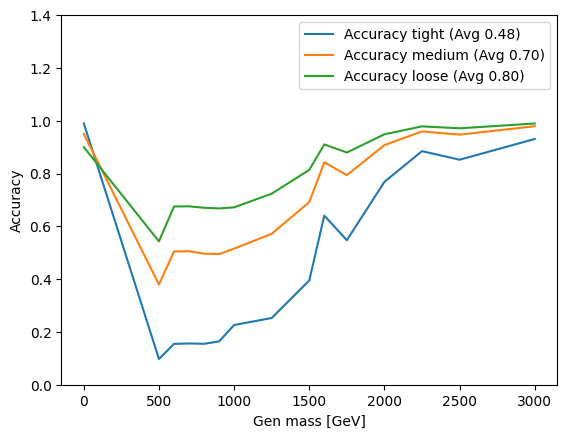

In [33]:
plt.plot(Masses, AccPredTight, label = "Accuracy tight (" + AccPredTightAvg + ")")
plt.plot(Masses, AccPredMedium, label = "Accuracy medium (" + AccPredMediumAvg + ")")
plt.plot(Masses, AccPredLoose, label = "Accuracy loose (" + AccPredLooseAvg + ")")

plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")